# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [ ]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install --upgrade scipy==1.7.3

In [2]:
# import libaries
import pandas as pd
import numpy as np
import scipy
import importlib  
import scipy.integrate
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import chi2

# import custom modules
emulator = importlib.import_module("analytics-course-scripts.scripts.modules.emulator")
plothelpers = importlib.import_module("analytics-course-scripts.scripts.modules.plothelpers")

# Import or Generate Dataset

In the beginning of each notebook you can make a decision whether you run the notebooks with already pre-generated runs which will be just imported or you will generate your own doe dataset from insilico model. For further information about the process emulator for cell culture fed-batch processes, check the script "00_Process_Characterization.ipynb" or the Powerpoint presentation "Simplified InSilico Model.pptx".

* For dataset import set `select_dataset_source = "import"`.
* For generating data set `select_dataset_source = "generate"`.

For first time running the notebook, we recommend choosing the "import" option.

 

In [3]:
# Select dataset source
select_dataset_source = "import"

In [4]:
if select_dataset_source == "import":
    # Define filename to import
    filename = "owu.csv"
    filepath = "/content/analytics-course-scripts/scripts/datasets/"
    # Import OWU data
    owu = pd.read_csv(filepath+filename,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(int(len(owu)/15))),list(range(15))], names=["run","time"])
    # Import DOE data
    doe = pd.read_csv(filepath+filename.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])

In [5]:
if select_dataset_source == "generate":
    # Model parameters
    mu_g_max = 0.05;
    mu_d_max = 0.025;
    K_g_Glc  = 1;
    K_I_Lac  = 30;
    K_d_Lac  = 50;
    k_Glc    = 0.04;
    k_Lac    = 0.06;
    k_Prod   = 1;

    # Process parameters
    feed_start = [1, 4]
    feed_end = [8, 12]
    Glc_feed_rate = [5, 20]
    Glc_0 = [10, 80.0]
    VCD_0 = [0.1, 1.0]

    var_lims = {"mu_g_max":mu_g_max,"mu_d_max": mu_d_max,"K_g_Glc" : K_g_Glc,"K_I_Lac" : K_I_Lac,"K_d_Lac" : K_d_Lac,"k_Glc" : k_Glc,"k_Lac" : k_Lac,"k_Prod" : k_Prod,"feed_start" : feed_start, "feed_end" : feed_end,"Glc_feed_rate" : Glc_feed_rate, "Glc_0" : Glc_0, "VCD_0" : VCD_0}

    # Define the number of experiments
    num_runs = 50
    # Define the filename for the dataset
    filename = "owu.csv"
    filepath = "/content/"
    # Generate Dataset
    owu = emulator.generate_data(var_lims, num_runs, filename)
    # Import OWU
    owu = pd.read_csv(filepath+filename,index_col=None, usecols = ["X:VCD", "X:Glc", "X:Lac", "X:Titer","W:Feed"])
    owu.index = pd.MultiIndex.from_product([list(range(num_runs)),list(range(15))], names=["run","time"])
    # Import DOE
    doe = pd.read_csv(filepath+filename.replace(".csv","_doe.csv"),index_col=None, usecols =["feed_start","feed_end","Glc_feed_rate","Glc_0","VCD_0"])

# Exploratory Analysis via PCA

*   Why is it important to visualize and understand the data, not only in univariate setting, but also in multivariate?
*   What insights can multivariate analysis provide?
*   What conclusions can be made from PCA on OWU matrix?
*   What conclusions can be made from PCA on BWU matrix?




## OWU and BWU Unfolding

First we need to distinguish between different type of variables and different types of unfolding.

Variable Types:

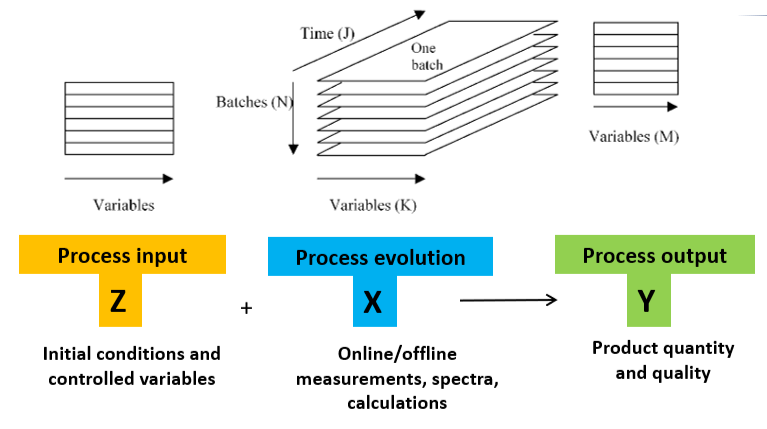

Unfolding types:

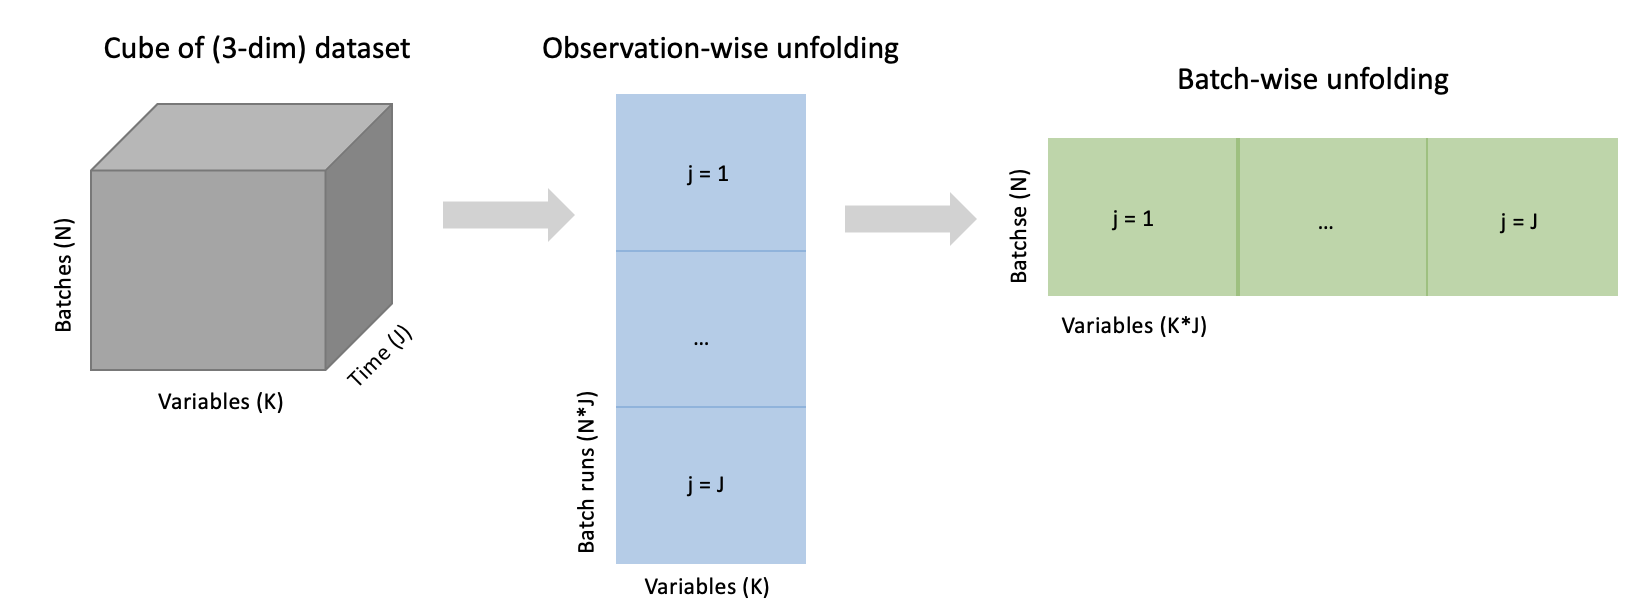

# PCA of OWU matrix

In this section, we use generated experiments using a Latin Hypercube design (LHD) from previous notebook. This will be used to create an observation-wise unfolder (OWU) matrix that will be analyzed using Principle Component Analysis (PCA).


### Visualize the OWU matrix

In the OWU matrix, the 1st column corresponds to VCD, the 2nd to glucose, the 3rd to lactate, the 4th to titer, and the 5th to the feed rate.


In [6]:
owu

X:VCD      X:Glc       X:Lac      X:Titer  W:Feed
run time                                                       
0   0      0.550000  45.000000    0.000000     0.000000     0.0
    1      1.725244  44.008188    1.489389     0.054632     0.0
    2      4.779558  41.089619    5.872389     1.311539    12.5
    3     10.278397  40.271478   16.487303    15.870869    12.5
    4     15.886799  40.083603   35.542541    85.824621    12.5
...             ...        ...         ...          ...     ...
49  10     6.862589  66.962134  146.180650  1078.530371     0.0
    11     4.427064  73.787984  154.252563  1171.208118     0.0
    12     2.799119  70.388990  159.354590  1230.611358     0.0
    13     1.808446  68.216450  162.615752  1268.882113     0.0
    14     1.183911  66.803478  164.736779  1293.894036     0.0

[750 rows x 5 columns]


In the DOE matrix, the 1st column corresponds to feed_start, the 2nd to feed_end, the 3rd to Glc_feed_rate, the 4th to initial Glc, and the 5th to the initial VCD.

In [7]:
doe

feed_start   feed_end  Glc_feed_rate      Glc_0     VCD_0
0     2.500000  10.000000      12.500000  45.000000  0.550000
1     1.948980  10.244898      18.622449  40.714286  0.274490
2     3.295918   9.346939      14.642857  17.857143  0.127551
3     3.479592   9.020408      15.561224  47.857143  0.843878
4     1.459184   9.591837       7.295918  33.571429  0.421429
5     3.418367   9.265306       8.214286  45.000000  0.403061
6     1.153061   8.448980      17.091837  67.857143  0.862245
7     2.438776   8.122449      14.336735  10.714286  0.898980
8     2.744898  11.551020       9.132653  27.857143  0.292857
9     2.316327   9.183673       5.459184  75.000000  0.256122
10    2.071429   9.918367      10.051020  25.000000  0.550000
11    3.112245  10.897959       5.765306  66.428571  0.311224
12    3.602041  10.163265      10.663265  53.571429  0.641837
13    1.030612  11.224490      12.806122  43.571429  0.807143
14    1.214286   9.755102      11.581633  62.142857  0.880612
15    3.969388  11.387755      13.112245  36.428571  0.458163
16    3.908163  10.979592      14.030612  55.000000  0.531633
17    1.887755  11.795918      18.928571  13.571429  0.586735
18    2.867347   8.040816      12.193878  23.571429  0.660204
19    2.255102   9.428571      17.704082  77.857143  0.825510
20    2.193878   9.673469      18.316327  37.857143  0.678571
21    2.132653   8.367347       5.153061  12.142857  0.237755
22    2.622449   8.285714      19.540816  49.285714  0.954082
23    1.642857  11.714286       9.744898  15.000000  0.752041
24    3.357143  11.142857      19.234694  29.285714  0.439796
25    2.928571  11.306122      12.500000  19.285714  0.605102
26    1.091837  10.734694       6.377551  52.142857  0.145918
27    3.846939  11.061224       7.602041  69.285714  0.770408
28    3.234694   8.530612      11.887755  73.571429  0.329592
29    2.989796   8.693878      15.867347  30.714286  0.788776
30    1.275510   8.204082      19.846939  22.142857  0.109184
31    2.806122  10.571429       6.683673  20.714286  0.568367
32    3.663265  11.632653      18.010204  60.714286  0.917347
33    3.785714  10.653061       9.438776  16.428571  0.219388
34    1.704082   8.938776      16.785714  72.142857  0.623469
35    1.397959   9.836735      11.275510  70.714286  0.990816
36    1.520408  10.408163      13.724490  35.000000  0.476531
37    3.051020  11.469388      16.479592  79.285714  0.366327
38    2.500000   8.857143       7.908163  26.428571  0.384694
39    3.540816  11.959184      17.397959  50.714286  0.182653
40    2.010204  11.877551      15.255102  32.142857  0.164286
41    1.581633  10.326531       8.826531  56.428571  0.494898
42    1.765306   9.510204      16.173469  46.428571  0.972449
43    3.724490  10.489796      10.969388  76.428571  0.935714
44    1.336735   9.102041      13.418367  65.000000  0.733673
45    2.377551   8.612245       6.989796  59.285714  0.513265
46    2.683673   8.775510      10.357143  57.857143  0.201020
47    3.173469  10.000000       8.520408  63.571429  0.696939
48    2.561224  10.081633       6.071429  39.285714  0.715306
49    1.826531  10.816327      14.948980  42.142857  0.347959

### Plot correlation matrix

The OWU matrix is used to plot the degree of correlation between the different variables.

In [8]:
fig = px.imshow(owu.corr())
fig.update_layout(title='Correlation Matrix among X variables')
fig.show()

### Unnormalized PCA

PCA is run on the OWU matrix, but without any variable normalization.



In [9]:
# Select number of components
select_n_components = 5

In [10]:
# Run PCA
owupca = PCA(n_components = select_n_components)
owupca.fit(owu)
owu_expl_var = owupca.explained_variance_
owu_expl_var_ratio = owupca.explained_variance_ratio_
owupca_n_comp = list(range(1,owupca.n_components_+1))

In [11]:
# Explained Variance Plot
fig = px.line(x=owupca_n_comp, y=1-owu_expl_var_ratio, color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
fig.add_bar(x=owupca_n_comp, y=owu_expl_var_ratio, name="Individual explained variance")
fig.show()

We can explain 99% of the variance with 1st principal component. Is that correct? Is something else incorrect about this analysis?

### Normalized PCA

PCA is run on the OWU matrix, but this time the variables are first normalized with respect to their mean and standard deviation. This ensures that each variable has equal contribution to the variance explained by the principal components


In [12]:
# Scale data by mean and standard deviation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(owu)

In [13]:
# Run PCA on scaled data
owupca.fit(scaled_data)
owu_expl_var = owupca.explained_variance_
owu_expl_var_ratio = owupca.explained_variance_ratio_
owupca_n_comp = list(range(1,owupca.n_components_+1))
owucomponents = owupca.fit_transform(scaled_data)

In [14]:
# Plot Explained Variance plots
fig = px.line(x=owupca_n_comp, y=1-owu_expl_var_ratio, color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color="Legend"))
fig.add_bar(x=owupca_n_comp, y=owu_expl_var_ratio, name="Individual explained variance")
fig.show()

### Plot scores and loadings

In the following plot, the PCA loadings are plotted together with the observation scores.

You can switch around which principal components are displayed on which axis by changing `select_x_pca` and `select_y_pca`

Here you can also apply same coloring options as in previous script. The options for `select_color` are:
* "Run_id" runs are colored by the order in which they appear in the dataset.
* "Time_id" runs are colored by the time evolution of the cell culture process.
* "Titer_14" runs are colored by the amount of Titer at day 14 or the experiments.
* "Glc_0" run are colored by the designed initial Glucose level
* "VCD_0" run are colored by the designed initial VCD level
* "feed_start" run are colored by the designed feeding start day 
* "feed_end" run are colored by the designed feeding end day
* "Glc_feed_rate" run are colored by the designed Glucose feed rate

In [15]:
# Principal component on x-axis
select_x_pca = 1
# Principal component on y-axis
select_y_pca = 2
# Color plots by
select_color = "Titer_14"
# Highlight run
select_highlight = 2

In [16]:
# Score plot of PCA
if select_color == "Run_id":
    color_idx=owu.index.get_level_values("run")
elif select_color == "Time_id":
    color_idx=owu.index.get_level_values("time")
elif select_color == "Titer_14":
    color_idx =np.repeat(np.array(owu["X:Titer"][:,14]),15)
elif select_color in doe.columns:
    color_idx = np.repeat(np.array(doe[select_color]),15)
else: 
    color_idx = None

fig = px.scatter(x=owucomponents[:,select_x_pca-1], y=owucomponents[:,select_y_pca-1], color=color_idx, title="PCA Score plot", labels={'x':"Principal Component - "+str(select_x_pca), 'y':"Principal Component - "+str(select_y_pca), 'color':str(select_color)})    
if select_highlight is not None:
    fig.add_trace(go.Scatter(x=owucomponents[owu.index.get_level_values(0) ==select_highlight,select_x_pca-1],y=owucomponents[owu.index.get_level_values(0) ==select_highlight,select_y_pca-1],name = "Run " +str(select_highlight)))
fig.show()

In [17]:
# Loading plot of PCA
owu_loadings = owupca.components_.T * np.sqrt(owupca.explained_variance_)
owu_features = list(owu.columns)

fig = px.scatter(x=[0,0], y=[0,0], labels={'x':"Principal Component - "+str(select_x_pca), 'y':"Principal Component - "+str(select_y_pca)}, title="PCA Loading plot")
for i, feature in enumerate(owu_features):
    fig.add_shape(type='line', x0=0, y0=0, x1=owu_loadings[i, select_x_pca-1], y1=owu_loadings[i, select_y_pca-1])
    fig.add_annotation(x=owu_loadings[i, select_x_pca-1], y=owu_loadings[i, select_y_pca-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature)
fig.show()


In [18]:
# Mahalanobis distance of observations (equal to the euclidean distance in PCA space)
emp_cov = EmpiricalCovariance().fit(scaled_data)
mahalanobis = emp_cov.mahalanobis(scaled_data)
T2threshold = chi2.ppf(0.95, scaled_data.shape[1]-1)
fig = px.bar(x=list(range(len(mahalanobis))),y=mahalanobis, labels=dict(x="OWU observation Id.", y="Mahalanobis distance"), title="Mahalanobis distance with 95% Confidence Interval")
fig.add_hline(y=T2threshold)
fig.show()


# PCA of BWU matrix

In the BWU unfolding, the number of rows corresponds to individual experiment runs and each variable like `X:VCD` is unfolded into multiple variables over time, such as `X:VCD:0`, `X:VCD:1`, ..., `X:VCD:14`.



### Visualize the BWU matrix

In the BWU matrix, the 1st column corresponds to VCD at day 0, the 2nd to glucose at day 0, the 3rd to lactate at day 0, the 4th to titer at day 0, and the 5th to the feed rate at day 0. This is repeated for day 1 and the following days. So, column 6 corresponds to VCD at day1, column 7 corresponds to Glc at day1, ..., column 11 corresponds to VCD at day2, etc.

In [19]:
# Transform OWU to BWU
bwu = emulator.generate_bwu(owu)
target = emulator.generate_y(bwu)

In [32]:
# Visualise BWU matrix
bwu

X:VCD:0   X:VCD:1   X:VCD:2    X:VCD:3    X:VCD:4    X:VCD:5    X:VCD:6  \
0   0.550000  1.725244  4.779558  10.278397  15.886799  18.568089  18.099141   
1   0.274490  0.871876  2.589262   6.529319  12.160305  15.860577  15.657798   
2   0.127551  0.394527  1.182078   3.245514   7.422644  12.957409  16.940040   
3   0.843878  2.609587  6.769304  12.917048  17.673164  18.962614  17.510225   
4   0.421429  1.320115  3.754135   8.637166  14.486637  18.036687  18.229667   
5   0.403061  1.274492  3.663684   8.505169  14.369815  17.987947  18.241245   
6   0.862245  2.674991  6.822434  12.043234  14.253106  12.635555   9.337354   
7   0.898980  2.561678  6.043656  10.256821  14.236500  15.979165  15.381042   
8   0.292857  0.917564  2.680033   6.607004  12.290788  16.780218  18.032878   
9   0.256122  0.823632  2.468081   6.202015  11.450645  15.366139  16.636512   
10  0.550000  1.691673  4.608217   9.866154  15.381975  18.134407  17.648349   
11  0.311224  0.996266  2.942566   7.184826  12.917820  17.059090  18.108461   
12  0.641837  2.010582  5.458865  11.253189  16.620922  18.798180  17.912880   
13  0.807143  2.495524  6.525910  12.568167  17.213925  18.428697  17.027948   
14  0.880612  2.728300  6.990020  12.780025  16.474579  16.852641  15.147646   
15  0.458163  1.436060  4.051277   9.099637  14.759322  17.840741  17.694876   
16  0.531633  1.676173  4.673522  10.127787  15.779086  18.561993  18.158660   
17  0.586735  1.736335  4.523534   9.596952  15.120833  18.080074  17.910016   
18  0.660204  2.013399  5.332241  10.748125  15.721121  17.719074  16.644492   
19  0.825510  2.565270  6.585087  12.085842  14.959729  13.770217  10.425172   
20  0.678571  2.104363  5.637695  11.463278  16.721219  18.659512  17.559377   
21  0.237755  0.710774  2.006489   4.987199   9.837366  14.117055  12.181219   
22  0.954082  2.935198  7.443830  13.698282  18.118923  18.885463  16.996022   
23  0.752041  2.222683  5.634616  11.083981  15.947031  17.610336  15.070374   
24  0.439796  1.369610  3.856184   8.706726  14.325726  17.773284  18.067698   
25  0.605102  1.831662  4.864024   9.930551  14.809764  17.029913  16.180803   
26  0.145918  0.469672  1.456194   4.058820   8.960257  14.322524  17.340623   
27  0.770408  2.402420  6.297320  12.189558  17.066195  18.708679  17.545165   
28  0.329592  1.054945  3.092880   7.400292  12.874737  16.188860  16.396373   
29  0.788776  2.415595  6.280322  12.140790  16.933189  18.502586  17.307805   
30  0.109184  0.342077  1.051384   3.038573   7.256163  12.220566  14.067326   
31  0.568367  1.730600  4.653286   9.715484  14.620346  14.623645  10.646003   
32  0.917347  2.836007  7.236253  13.428332  17.982718  19.010399  17.376844   
33  0.219388  0.671580  1.949564   4.945573   9.633479  13.850104  14.712065   
34  0.623469  1.960752  5.306759  10.489089  13.864778  13.289988  10.345672   
35  0.990816  3.051829  7.589743  13.168566  16.123124  15.860682  13.844892   
36  0.476531  1.490288  4.185534   9.362531  15.097241  18.158973  18.007309   
37  0.366327  1.170433  3.386097   7.840766  12.830300  14.658648  12.983878   
38  0.384694  1.196678  3.404224   7.920477  13.627506  17.343858  17.538950   
39  0.182653  0.586326  1.795771   4.852351  10.218077  15.518860  17.786754   
40  0.164286  0.521199  1.586581   4.344777   9.461147  14.852771  17.431430   
41  0.494898  1.564189  4.401058   9.655748  15.112630  17.846991  17.625207   
42  0.972449  2.985230  7.539696  13.776013  18.003725  18.604400  16.711223   
43  0.935714  2.889579  7.247856  13.089383  17.334482  18.348762  16.892725   
44  0.733673  2.292071  6.058747  11.569033  15.175848  15.169823  12.890563   
45  0.513265  1.621783  4.541675   9.904319  15.488039  18.314220  18.038468   
46  0.201020  0.646296  1.971984   5.245880  10.666217  15.560387  17.520364   
47  0.696939  2.181419  5.835892  11.697033  16.832591  18.736681  17.739523   
48  0.715306  2.216311  5.893624  11.782630  16.892942  18.589364  16.015618   
49  0

### Plot correlation matrix
The BWU matrix is used to plot the degree of correlation between the different variables.


In [22]:
fig = px.imshow(bwu.corr())
fig.update_layout(title='BWU Correlation Matrix among X variables')
fig.show()

### Normalized PCA

PCA is run on the BWU matrix, bu this time the variables are first normalized with respect to their mean and standard deviation.


In [53]:
# Select number of components
select_n_components = 15

In [55]:
# Scale data by mean and standard deviation and run PCA
bwupca = PCA(n_components=min(min(bwu.shape),select_n_components))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(bwu)
bwupca.fit(scaled_data)
bwu_expl_var = bwupca.explained_variance_
bwu_expl_var_ratio = bwupca.explained_variance_ratio_
bwupca_n_comp = list(range(1,bwupca.n_components_+1))
bwu_components = bwupca.fit_transform(scaled_data)

In [56]:
# Plot Explained Variance plots
fig = px.line(x=bwupca_n_comp, y=1-bwu_expl_var_ratio, color=px.Constant("Cumulative explained variance"), labels=dict(x="Principal component index", y="Explained Variance Ratio", color=""))
fig.add_bar(x=bwupca_n_comp, y=bwu_expl_var_ratio, name="Individual explained variance")
fig.show()

### Plot scores and loadings

In the following plot, the PCA loadings are plotted first with the loadings and then without.


In [57]:
# Principal component on x-axis
select_x_pca = 1
# Principal component on y-axis
select_y_pca = 2
# Color plots by
select_color = "Titer_14"

In [58]:
# Score plot of PCA
if select_color == "Run_id":
    color_idx=np.array(bwu.index.get_level_values(0))
elif select_color == "Titer_14":
    color_idx = np.array(owu["X:Titer"][:,14])
elif select_color in doe.columns:
    color_idx = np.array(doe[select_color])
else: 
    color_idx = None
fig = px.scatter(x=bwu_components[:,select_x_pca-1], y=bwu_components[:,select_y_pca-1], color =color_idx, labels={'x':"Principal Component - "+str(select_x_pca), 'y':"Principal Component - "+str(select_y_pca), 'color':str(select_color)}, title="PCA BWU Score plot")
fig.show()

In [59]:
# Loading plot of PCA
bwu_loadings = bwupca.components_.T * np.sqrt(bwupca.explained_variance_)
bwu_features = list(bwu.columns)

fig = px.scatter(x=[0,0], y=[0,0], labels={'x':"Principal Component - "+str(select_x_pca), 'y':"Principal Component - "+str(select_y_pca)}, title="PCA Loading plot")
for i, feature in enumerate(bwu_features):
    fig.add_shape(type='line', x0=0, y0=0, x1=bwu_loadings[i, select_x_pca-1], y1=bwu_loadings[i, select_y_pca-1])
    fig.add_annotation(x=bwu_loadings[i, select_x_pca-1], y=bwu_loadings[i, select_y_pca-1], ax=0, ay=0, xanchor="center", yanchor="bottom", text=feature)
fig.show()


In [60]:
# Select which loading to plot
select_x_pca = 1

In [63]:
# Loading plot of PCA alternative
bwu_loadings = bwupca.components_.T * np.sqrt(bwupca.explained_variance_)
bwu_loading = bwu_loadings[:,select_x_pca-1]
bwu_features = list(bwu.columns)

fig = px.bar(x=bwu_features, y=bwu_loading,labels={'x':"Variable", 'y':"Loading of PC - "+str(select_x_pca)}, title="PCA Loading plot")
fig.show()

# Tasks: 

1. How would you use the pca analysis to find high Titer experiments.
2. Compute Mahalanobis distances on BWU matrix.
3. Normalize data by median VCD and run PCA on OWU matrix.



